In [1]:
# https://ai.plainenglish.io/audio-data-music-genre-classification-8fe58cc9444e
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments
import torchaudio
import torchaudio.transforms as T
import torch
import numpy as np
import os

In [2]:
# model_id = "ntu-spml/distilhubert"
model_path = 'distilhubert-finetuned-rebetika_voice/checkpoint-110'
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_path, do_normalize=True, return_attention_mask=True
)

sampling_rate = feature_extractor.sampling_rate

In [3]:
sampling_rate = feature_extractor.sampling_rate
sampling_rate

16000

In [4]:
from datasets import load_dataset, Audio

dataset = load_dataset('audiofolder', data_dir='Rebetika_whole')

Resolving data files:   0%|          | 0/94 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

In [5]:
# resample audio files to desired sample rate
dataset = dataset.cast_column('audio', Audio(sampling_rate=sampling_rate))

In [6]:
max_duration = 10.0

def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

In [7]:
dataset_encoded = dataset.map(
    preprocess_function,
    remove_columns=['audio'],
    batched=True,
    batch_size=100,
    num_proc=1,
)
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 94
    })
    test: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 19
    })
})

In [8]:
id2label_fn = dataset['train'].features['label'].int2str
id2label_fn(dataset['train'][50]['label'])

'Tsaousakis'

In [9]:
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(dataset_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

id2label['2']

'Ninou'

In [10]:
num_labels = len(id2label)

model = AutoModelForAudioClassification.from_pretrained(
    model_path,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)

In [11]:
dataset_encoded['train'][50]['input_values']

[0.07224509865045547,
 0.13294261693954468,
 0.13131651282310486,
 0.15067066252231598,
 0.141509547829628,
 0.12485352903604507,
 0.08748818933963776,
 0.05693197622895241,
 0.02373609133064747,
 -0.007719882298260927,
 -0.047596294432878494,
 -0.08852198719978333,
 -0.12591710686683655,
 -0.1521281599998474,
 -0.16823716461658478,
 -0.1704172044992447,
 -0.16213464736938477,
 -0.14774727821350098,
 -0.12691938877105713,
 -0.10563749074935913,
 -0.07703838497400284,
 -0.041294924914836884,
 -0.010145660489797592,
 0.01821960136294365,
 0.043337609618902206,
 0.06274880468845367,
 0.07906853407621384,
 0.08761299401521683,
 0.09355401992797852,
 0.0998564288020134,
 0.10723018646240234,
 0.10179775953292847,
 0.09566565603017807,
 0.08325561881065369,
 0.06961003690958023,
 0.050589919090270996,
 0.029236603528261185,
 0.004911589901894331,
 -0.020897677168250084,
 -0.030594466254115105,
 -0.031149843707680702,
 -0.03407001122832298,
 -0.036196764558553696,
 -0.026932640001177788,
 -0.

In [12]:
t = torch.FloatTensor( dataset_encoded['train'][50]['input_values'] )
tt = t.view(1, t.shape[0])
print(tt.shape)

torch.Size([1, 160000])


In [13]:
model.eval()

HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): HubertEncoder(
      (pos_conv_embed): HubertPositionalConvEmbedding(

In [57]:
h = model.hubert( tt ).last_hidden_state
print(h.shape) # (batch_size, sequence_length, hidden_size)
p = model.projector( h )
print(p.shape)
f = p.mean(axis=1)
print(f.shape)
fp = f.detach().numpy()
print(fp.shape)

torch.Size([1, 499, 768])
torch.Size([1, 499, 256])
torch.Size([1, 256])
(1, 256)


In [59]:
def extract_hubert(d):
    h = model.hubert( d ).last_hidden_state
    p = model.projector( h )
    f = p.mean(axis=1)
    return f.detach().numpy()

In [79]:
values = []
ids = []
for train_test in ['train', 'test']:
    for datapoint in dataset_encoded[train_test]:
        t = torch.FloatTensor( datapoint['input_values'] )
        values.append( extract_hubert( t.view(1, t.shape[0]) ) )
        ids.append( datapoint['label'] )

In [66]:
values_np = np.array(values).squeeze()

In [67]:
print(values_np.shape)

(113, 256)


In [68]:
from sklearn.manifold import TSNE

In [69]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(values_np)

In [70]:
print(X_embedded.shape)

(113, 2)


In [85]:
import matplotlib.pyplot as plt

In [107]:
labels = []
for i in ids:
    labels.append( id2label[str(i)] )

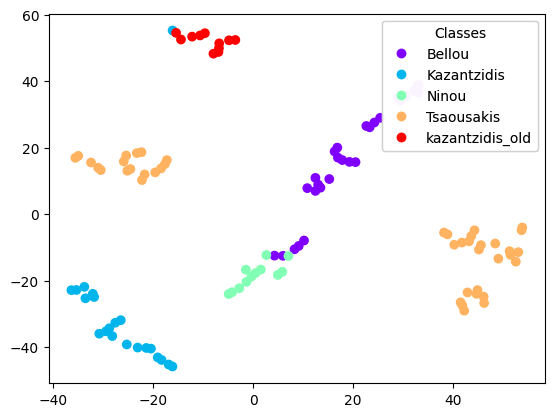

In [132]:
fig, ax = plt.subplots()

scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1], c=ids, cmap='rainbow')
legends = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
for i,t in enumerate(legends.get_texts()):
    t.set_text( id2label[str(i)] )
ax.add_artist(legends)

In [138]:
os.makedirs('figs', exist_ok=True)
fig.savefig('figs/tsne_whole.png', dpi=300)